In [19]:
import pandas as pd
from pyspark.sql.functions import col, explode
from pyspark import SparkContext
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.feature import * #CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import * #col, udf,regexp_replace,isnull
from pyspark.sql.types import * #StringType,IntegerType
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# For pipeline development
from pyspark.ml import Pipeline 
from pyspark import SparkContext, SparkConf
from pyspark.sql import HiveContext, Row
from pyspark.sql.types import IntegerType
import json
import sys
import pandas as pd


inputFile = 'mydata/health_data.csv'
# inputFile = 'mydata/sample.csv'

conf = SparkConf().setAppName("SparkSQLAirTransit")
SparkConf().set("spark.sql.legacy.timeParserPolicy","LEGACY")

sc = SparkContext.getOrCreate(conf=conf)
hiveCtx = HiveContext(sc)
print("Loading data from " + inputFile)

Loading data from mydata/health_data.csv


/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/context.py:718: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  warnings.warn(
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [20]:
df = hiveCtx.read.option("header",True).csv(inputFile,inferSchema =True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: integer (nullable = true)
 |-- drink: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [21]:
print('View the data sample and search for data')
pd.DataFrame(df.take(10), columns=df.columns).transpose()

View the data sample and search for data


,0,1,2,3,4,5,6,7,8,9
age,67,80,77,75,77,75,60,71,60,78
bmi,21,13,12,17,14,28,15,28,30,22
drink,0,0,1,1,1,0,1,0,1,0
heart_disease,1,1,1,0,1,0,1,1,0,1
diabetes,0,0,0,0,1,1,1,1,0,0


# data explore and feature enginnering

'''
Our dataset is a selection of columns from open source datasets for data exploration and analysis
More detailed column description can find clues from the following url：

https://archive.ics.uci.edu/ml/datasets/heart+Disease

This full database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

One file has been "processed", that one containing the Cleveland database. All four unprocessed files also exist in this directory.

To see Test Costs (donated by Peter Turney), please see the folder "Costs"
'''

In [22]:
mypd = pd.read_csv(inputFile)


# duplicate data check
mypd.drop(['bmi'], axis  = 1).duplicated().sum()

4999832

In [23]:
mypd.nunique()

age              21
bmi              21
drink             2
heart_disease     2
diabetes          2
dtype: int64

In [24]:
mypd.isnull().sum()


age              0
bmi              0
drink            0
heart_disease    0
diabetes         0
dtype: int64

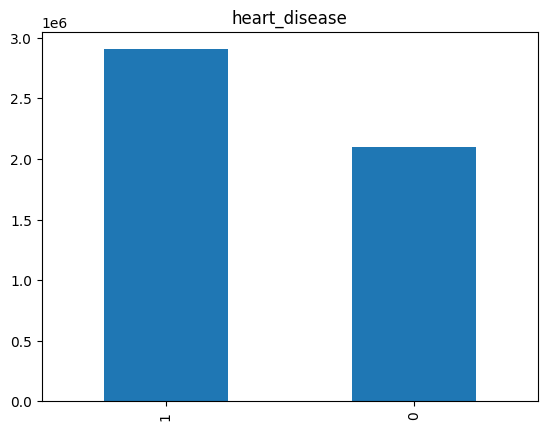

In [25]:
_ = mypd["heart_disease"].value_counts().plot(kind = 'bar', title = 'heart_disease')

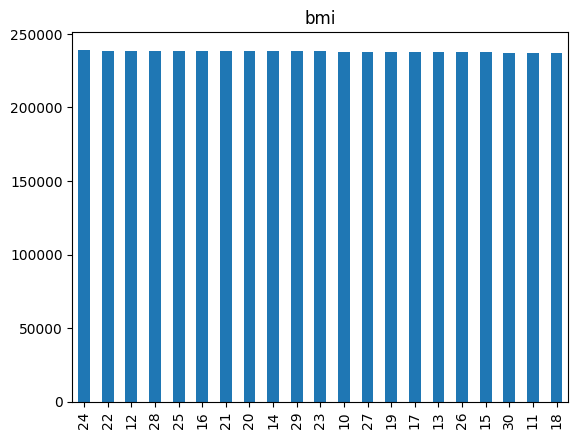

In [26]:
_ = mypd["bmi"].value_counts().plot(kind = 'bar', title = 'bmi')

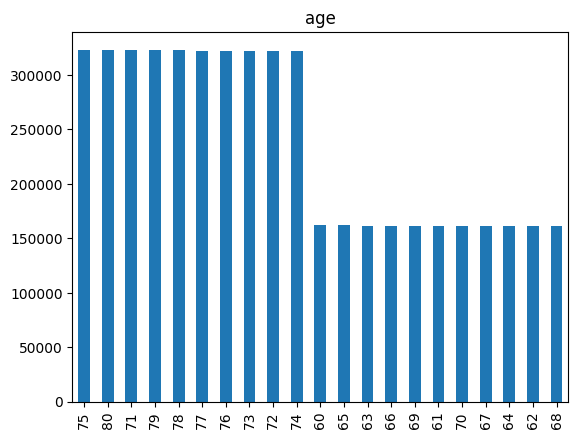

In [27]:
_ = mypd["age"].value_counts().plot(kind = 'bar', title = 'age')

'''
Computing the correlation between two series of data is a common operation in statistics. Many algorithms are provided in spark.ml to calculate pairwise correlations. The currently supported correlation algorithms are Pearson and Spearman. Correlation computes the correlation matrix for the input dataset using the specified method. The output is a DataFrame containing a correlation matrix of vector columns
'''

affinity analysis ----------------------------------------


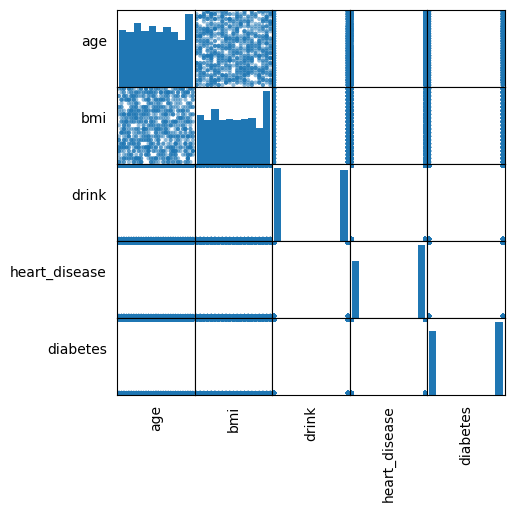

In [28]:
# df = hiveCtx.read.option("header",True).csv('mydata/sample.csv',inferSchema =True)

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

print('affinity analysis', '-'*40)
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(5, 5));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [29]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['age','bmi','drink','diabetes']
stages = []
# for categoricalCol in categoricalColumns:
#     stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#     encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#     stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'heart_disease', outputCol = 'label')
stages += [label_stringIdx]
numericCols = categoricalColumns
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [30]:

from pyspark.ml import Pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)

In [31]:
print('Data set split')
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Data set split
Training Dataset Count: 712
Test Dataset Count: 288


# random forest algorithm
'''
Random forest is an extended variant of bagging,
and after understanding the bagging method, random forest is much easier to learn. 
On the basis of building Bagging ensemble with decision tree as the base learner, 
RF further adds random attribute selection in the training process of decision tree. 
Specifically, the traditional decision tree selects an optimal attribute 
among all the candidate attributes of the current node (assuming there are d)
when selecting the attributes for division; while in RF, for each node of the base decision tree, 
first A subset containing k attributes is randomly selected from the set of candidate attributes of the node, 
and then an optimal attribute is selected from this subset for partitioning. 
The choice of the number of attributes k to be extracted is more important,
and is generally recommended. As a result, the "diversity" of the base learner 
of random forest comes not only from the perturbation of samples, but also from the perturbation of attributes, 
which further enhances the generalization ability of the final ensemble
'''

In [43]:
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import RandomForestClassifier
from matplotlib import pyplot as plt


lr = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
# lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

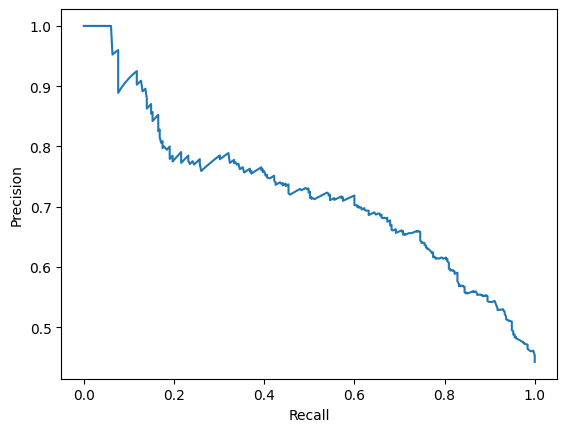

In [44]:
trainingSummary = lrModel.summary
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [45]:
print('Supervised Machine Learning Machine Forest Results：')
predictions = lrModel.transform(test)
predictions.select('age','bmi','drink','diabetes', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Supervised Machine Learning Machine Forest Results：
+---+---+-----+--------+-----+--------------------+----------+--------------------+
|age|bmi|drink|diabetes|label|       rawPrediction|prediction|         probability|
+---+---+-----+--------+-----+--------------------+----------+--------------------+
| 60| 10|    1|       1|  0.0|[9.55911591245743...|       1.0|[0.47795579562287...|
| 60| 28|    1|       0|  0.0|[8.32670628057956...|       1.0|[0.41633531402897...|
| 61| 14|    0|       1|  0.0|[6.96256505175078...|       1.0|[0.34812825258753...|
| 61| 14|    1|       1|  0.0|[7.41945929742792...|       1.0|[0.37097296487139...|
| 61| 25|    0|       1|  0.0|[6.76431408178946...|       1.0|[0.33821570408947...|
| 62| 11|    1|       0|  0.0|[10.0291741638174...|       0.0|[0.50145870819087...|
| 62| 15|    0|       1|  0.0|[8.35962505875697...|       1.0|[0.41798125293784...|
| 62| 20|    0|       1|  0.0|[7.34529438549631...|       1.0|[0.36726471927481...|
| 62| 22|    1|       1|

In [46]:
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import RandomForestClassifier
# lr = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

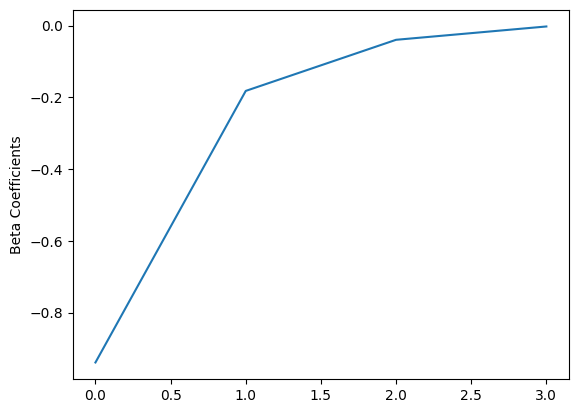

In [47]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

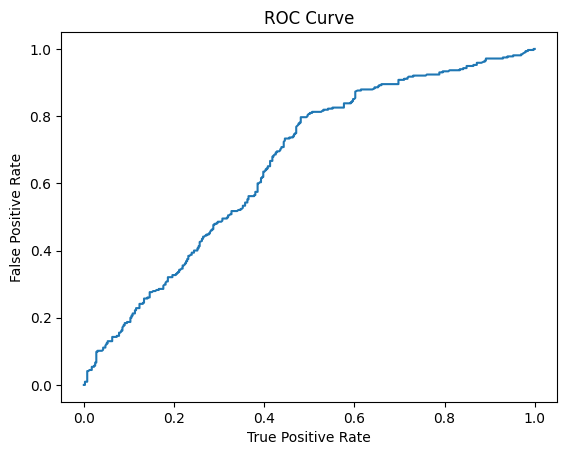

Training set areaUnderROC: 0.6607212826356403


In [48]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

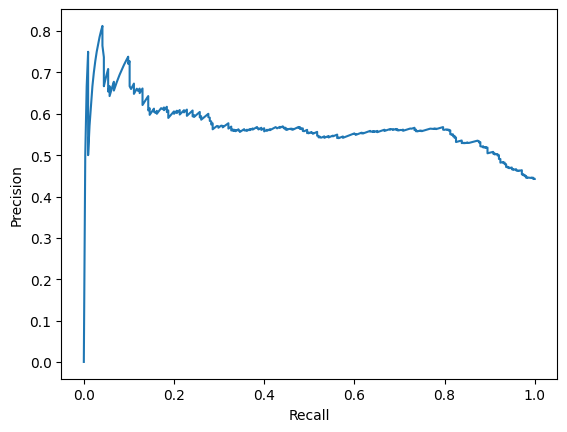

In [49]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [50]:
print('Supervised Machine Learning Logistic Regression Results：')
predictions = lrModel.transform(test)
predictions.select('age','bmi','drink','diabetes', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Supervised Machine Learning Logistic Regression Results：
+---+---+-----+--------+-----+--------------------+----------+--------------------+
|age|bmi|drink|diabetes|label|       rawPrediction|prediction|         probability|
+---+---+-----+--------+-----+--------------------+----------+--------------------+
| 60| 10|    1|       1|  0.0|[0.21021447718291...|       0.0|[0.55236094144014...|
| 60| 28|    1|       0|  0.0|[0.06852594770999...|       0.0|[0.51712478622977...|
| 61| 14|    0|       1|  0.0|[-0.6807555313792...|       1.0|[0.33609269668608...|
| 61| 14|    1|       1|  0.0|[0.25855178900438...|       0.0|[0.56428025619755...|
| 61| 25|    0|       1|  0.0|[-0.6561687548631...|       1.0|[0.34160077202125...|
| 62| 11|    1|       0|  0.0|[0.10932153381626...|       0.0|[0.52730319671023...|
| 62| 15|    0|       1|  0.0|[-0.6391237040622...|       1.0|[0.34544465414144...|
| 62| 20|    0|       1|  0.0|[-0.6279478965548...|       1.0|[0.34797599152145...|
| 62| 22|    1|    

In [51]:
print('Unsupervised machine learning kmean')
from pyspark.ml.clustering import KMeans

print('2 cluster experements:')
kmeans = KMeans(k=2, seed=1)  # 2 clusters here
model = kmeans.fit(df.select('features'))

Unsupervised machine learning kmean
2 cluster experements:


In [52]:
transformed = model.transform(df)
transformed.show()    

+-----+-------------------+---+---+-----+-------------+--------+----------+
|label|           features|age|bmi|drink|heart_disease|diabetes|prediction|
+-----+-------------------+---+---+-----+-------------+--------+----------+
|  1.0|[89.0,23.0,0.0,1.0]| 89| 23|    0|            0|       1|         1|
|  0.0|[87.0,29.0,0.0,0.0]| 87| 29|    0|            1|       0|         1|
|  1.0|[82.0,30.0,0.0,1.0]| 82| 30|    0|            0|       1|         1|
|  0.0|[76.0,20.0,1.0,0.0]| 76| 20|    1|            1|       0|         1|
|  1.0|[68.0,24.0,1.0,1.0]| 68| 24|    1|            0|       1|         0|
|  0.0|[81.0,11.0,1.0,1.0]| 81| 11|    1|            1|       1|         1|
|  1.0|[87.0,23.0,0.0,1.0]| 87| 23|    0|            0|       1|         1|
|  0.0|[75.0,22.0,1.0,0.0]| 75| 22|    1|            1|       0|         0|
|  1.0|[60.0,14.0,0.0,1.0]| 60| 14|    0|            0|       1|         0|
|  0.0|[90.0,29.0,0.0,1.0]| 90| 29|    0|            1|       1|         1|
|  0.0|[73.0

In [53]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):
    print('Unsupervised classification [k]=', K)
    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(df.select('features'))

    KMeans_transform=KMeans_fit.transform(df.select('features')) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

Unsupervised classification [k]= 2
Unsupervised classification [k]= 3
Unsupervised classification [k]= 4
Unsupervised classification [k]= 5
Unsupervised classification [k]= 6
Unsupervised classification [k]= 7
Unsupervised classification [k]= 8
Unsupervised classification [k]= 9
Unsupervised classification [k]= 10


Unsupervised classification


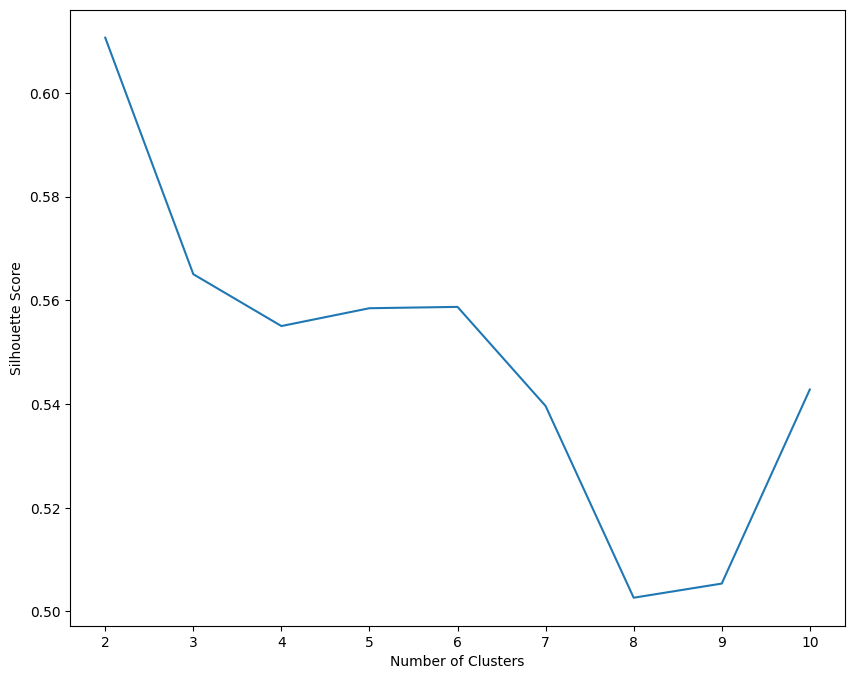

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
print('Unsupervised classification')